In [3]:
#Import all necessary modules
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

In [2]:
#Load in training data. 
matrix = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/train_data_.csv')
matrix = matrix.sample(random_state = 2023, frac = 1, ignore_index=True)  # shuffle
# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1).reset_index(drop = True)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop = True)

assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y = y_data_pre['annot']
print(y)

X_data=X_data.drop(['annot'], axis=1)
X=X_data.drop(['BDSPPatientID', 'ContactDate', 'hospital', 'Unnamed: 0', 'NoteFileName', 'Site'], axis=1) 
print(X)

      Unnamed: 0  BDSPPatientID ContactDate  \
0           1328      118166468  2019-02-10   
1           2377      151027760  2018-07-07   
2           2821      151147664  2018-08-25   
3            982      118696581  2022-05-10   
4           1150      114871134  2018-02-14   
...          ...            ...         ...   
1495         732      115864242  2021-04-05   
1496        2556      150772328  2012-07-18   
1497         640      119972331  2019-08-19   
1498        2001      151202679  2015-11-25   
1499        2218      151038873  2015-08-31   

                                   NoteFileName   Site  CT  MRI  acut sdh_pos  \
0     Notes_13376418603_2401628103_20190210.txt    MGB   1    1             0   
1      Notes_1130886747_2345800771_20180707.txt  BIDMC   0    0             0   
2     Notes_1131006147_26220317926_20180825.txt  BIDMC   0    0             0   
3     Notes_13620842071_8922329630_20220510.txt    MGB   1    1             0   
4     Notes_13361437832_163574

In [3]:
#Print Columns
x_columns=list(X.columns)
print(x_columns)

['CT', 'MRI', 'acut sdh_pos', 'brain injuri_pos', 'brain mri_pos', 'burr hole_pos', 'stabl sdh_pos', 'craniectomi_pos', 'craniotomi_pos', 'ct head_pos', 'drainag_pos', 'evacu_pos', 'head ct_pos', 'hematoma_pos', 'chronic sdh_pos', 'herniat_pos', 'intracrani hemorrhag_pos', 'intraparenchym hemorrhag_pos', 'midlin shift_pos', 'mva_pos', 'mvc_pos', 'neurosurgeri_pos', 'neurosurg intervent_pos', 'scan_pos', 'sdh_pos', 'subdur_pos', 'tbi_pos', 'tentorium_pos', 'thick_pos', 'trauma_pos', 'prior sdh_pos', 'recent sdh_pos', 'resolv sdh_pos', 'known sdh_pos', 'acut sdh_neg', 'brain injuri_neg', 'brain mri_neg', 'burr hole_neg', 'stabl sdh_neg', 'craniectomi_neg', 'craniotomi_neg', 'ct head_neg', 'drainag_neg', 'evacu_neg', 'head ct_neg', 'hematoma_neg', 'chronic sdh_neg', 'herniat_neg', 'intracrani hemorrhag_neg', 'intraparenchym hemorrhag_neg', 'midlin shift_neg', 'mva_neg', 'mvc_neg', 'neurosurgeri_neg', 'neurosurg intervent_neg', 'scan_neg', 'sdh_neg', 'subdur_neg', 'tbi_neg', 'tentorium_neg

In [6]:
#Counts the occurrences of each class in the target variable
from collections import Counter
print(Counter(y))  


Counter({0: 1131, 1: 369})


In [7]:
#Conducting 10 fold nested cross validation. 
all_predictions = []
all_true_labels = []
all_row_numbers = []

# outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X.columns}
fold_patient_ids = {f'fold_{i+1}': {'train': [], 'test': []} for i in range(10)}

# Initialize KFold
gkf = GroupKFold(n_splits=10)
 

for cvi, (train_index, test_index) in enumerate(gkf.split(X,y,groups=y_data_pre['BDSPPatientID'])): 
#to link patientid to cv fold number
# for train_index, test_index in gkf.split(X,y,groups=y_data_pre['BDSPPatientID']):
    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]

    fold_patient_ids[f'fold_{cvi+1}']['train'].extend(y_data_pre.loc[train_index, 'BDSPPatientID'].tolist())
    fold_patient_ids[f'fold_{cvi+1}']['test'].extend(y_data_pre.loc[test_index, 'BDSPPatientID'].tolist())

   
    model = LogisticRegression(
            penalty='elasticnet',
            class_weight=None, random_state=2023,
            solver='saga', max_iter=10000)
   
    search_spaces = {
         'C': (1e-4, 1e+4, 'log-uniform'), 
         'l1_ratio': (0.01, 0.99),
    }
    model_cv = BayesSearchCV(model,
            search_spaces,
            n_iter=50, scoring='roc_auc', n_jobs=47,
            cv=10, random_state=2023)
    
    model_cv.fit(Xtr, ytr)

    #Find the Best hyperparameters and append them
    best_hparams = model_cv.best_params_
    best_C = best_hparams['C']
    best_l1_ratio = best_hparams['l1_ratio']
    final_Cs.append(best_C)
    final_l1.append(best_l1_ratio)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:,1]     
    yte_pred = model.predict_proba(Xte)[:,1]    

    fpr, tpr, cutoffs = roc_curve(ytr, ytr_pred) 
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]  
    yte_pred_bin =(yte_pred>best_cutoff).astype(int)
    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append( f1_score(yte, yte_pred_bin) )
    cf_cv.append( confusion_matrix(yte, yte_pred_bin) )
    predictions.append(yte_pred_bin)


    model_filename = f'model_train_allhospitals_Notes+ICD+Med_fold{cvi+1}.pickle'
    with open(model_filename, 'wb') as f:
        pickle.dump({'model':model, 'cutoff':best_cutoff}, f)

    fpr, tpr, cutoffs = roc_curve(yte, yte_pred) 

    # Store the predictions and true labels for this fold
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    # Save info for the plots
    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    # Extract feature importances (coefficients)
    feature_importances = model.coef_[0]
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)
fold_patient_ids_list = []
for fold, ids in fold_patient_ids.items():
    for train_id in ids['train']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'train', 'patient_id': train_id})
    for test_id in ids['test']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'test', 'patient_id': test_id})
fold_patient_ids_df = pd.DataFrame(fold_patient_ids_list)
fold_patient_ids_df.to_csv('fold_patient_ids.csv', index=False)



Feature importances for this fold:
                    Feature  Importance
24                  sdh_pos    3.599831
66              history_sdh    1.313880
3          brain injuri_pos    1.212859
21         neurosurgeri_pos    1.104837
70             ICD_852.2or3    1.090072
..                      ...         ...
54  neurosurg intervent_neg   -0.478916
4             brain mri_pos   -0.508503
31           recent sdh_pos   -0.930559
33            known sdh_pos   -0.984611
1                       MRI   -1.008511

[71 rows x 2 columns]
[0.9581766917293234]
[0.8639672266257359]
Feature importances for this fold:
             Feature  Importance
24           sdh_pos    4.045221
66       history_sdh    1.933106
3   brain injuri_pos    1.137914
21  neurosurgeri_pos    1.074752
18  midlin shift_pos    0.960080
..               ...         ...
14   chronic sdh_pos   -0.392594
4      brain mri_pos   -0.415065
31    recent sdh_pos   -0.539451
1                MRI   -0.770449
33     known sdh_pos  

In [8]:
#Print AUC_ROC and AUC_PR
print(np.mean(auc_cv)) 
print(np.mean(auc_pr))

0.9732040987117004
0.8893830501363318


/tmp/ipykernel_2270/2751595837.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_importance_df.loc[i, 'Feature'] = feature


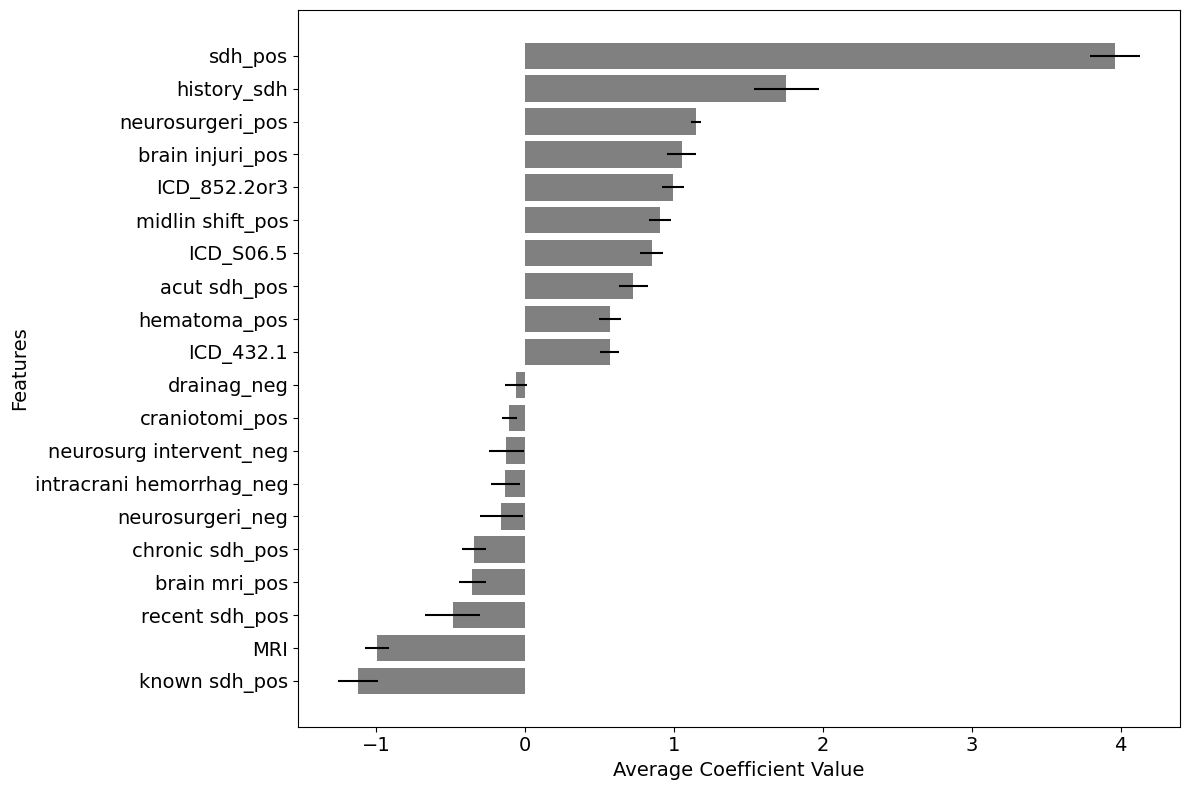

In [9]:
#Aggregate feature importances by averaging over folds
feature_importance_df = pd.DataFrame(data={'Feature':[], 'Importance':[], 'Importance_se':[]})

for i, (feature, importances) in enumerate(feature_importances_dict.items()):
    feature_importance_df.loc[i, 'Feature'] = feature
    feature_importance_df.loc[i, 'Importance'] = np.mean(importances)
    feature_importance_df.loc[i, 'Importance_se'] = np.std(importances)/np.sqrt(len(importances))

feature_importance_df = feature_importance_df.sort_values('Importance', axis=0, ignore_index=True, ascending=False)

feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/both_feat_importances_.csv', index=False)

#Select top 10 and bottom 10 features
top_features = feature_importance_df.Feature.iloc[:10]
top_importances = feature_importance_df.Importance.iloc[:10]
top_importances_se = feature_importance_df.Importance_se.iloc[:10]
bottom_features = feature_importance_df.Feature.iloc[-10:]
bottom_importances = feature_importance_df.Importance.iloc[-10:]
bottom_importances_se = feature_importance_df.Importance_se.iloc[-10:]

#Combine top and bottom features for plotting
plot_features = pd.concat([top_features, bottom_features])
plot_importances = pd.concat([top_importances, bottom_importances])
plot_importances_se = pd.concat([top_importances_se, bottom_importances_se])

#Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='grey', xerr=2*plot_importances_se, ecolor='black') 
plt.xlabel('Average Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().invert_yaxis()  
#Invert y-axis to have the most important feature on top
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  

# Save plot
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/both_feat_importances_.png')

# Show plot
plt.show()


/tmp/ipykernel_2270/3540133833.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_importance_df.loc[i, 'Feature'] = feature


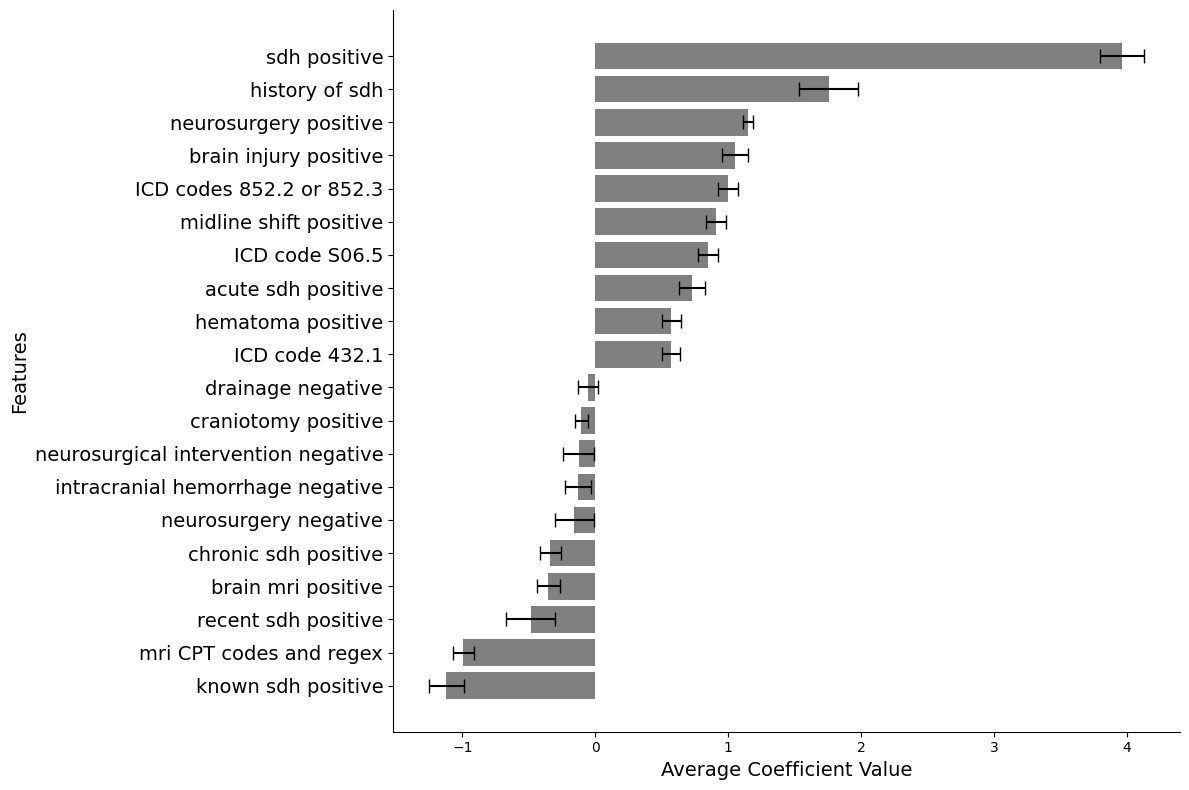

In [18]:
# Define custom feature names
custom_plot_features = [
    "sdh positive", "history of sdh", "neurosurgery positive", "brain injury positive", 
    "ICD codes 852.2 or 852.3", "midline shift positive", "ICD code S06.5", "acute sdh positive",
    "hematoma positive", "ICD code 432.1", "drainage negative", "craniotomy positive", 
    "neurosurgical intervention negative", "intracranial hemorrhage negative", "neurosurgery negative", 
    "chronic sdh positive", "brain mri positive", "recent sdh positive", "mri CPT codes and regex", "known sdh positive"
]

# Aggregate feature importances by averaging over folds
feature_importance_df = pd.DataFrame(data={'Feature':[], 'Importance':[], 'Importance_se':[]})

for i, (feature, importances) in enumerate(feature_importances_dict.items()):
    feature_importance_df.loc[i, 'Feature'] = feature
    feature_importance_df.loc[i, 'Importance'] = np.mean(importances)
    feature_importance_df.loc[i, 'Importance_se'] = np.std(importances)/np.sqrt(len(importances))

feature_importance_df = feature_importance_df.sort_values('Importance', axis=0, ignore_index=True, ascending=False)

feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/both_feat_importances_.csv', index=False)

# Select top 10 and bottom 10 features
top_features = feature_importance_df.Feature.iloc[:10]
top_importances = feature_importance_df.Importance.iloc[:10]
top_importances_se = feature_importance_df.Importance_se.iloc[:10]
bottom_features = feature_importance_df.Feature.iloc[-10:]
bottom_importances = feature_importance_df.Importance.iloc[-10:]
bottom_importances_se = feature_importance_df.Importance_se.iloc[-10:]

# Combine top and bottom features for plotting
plot_features = pd.concat([top_features, bottom_features])
plot_importances = pd.concat([top_importances, bottom_importances])
plot_importances_se = pd.concat([top_importances_se, bottom_importances_se])

# Ensure the length of custom features matches the length of plot_features
assert len(custom_plot_features) == len(plot_features), "The number of custom features must match the number of plot features."

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='grey', xerr=2*plot_importances_se, ecolor='black', capsize=5)  
plt.xlabel('Average Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
# Invert y-axis to have the most important feature on top
plt.gca().invert_yaxis()  

# Set custom y-axis labels
plt.yticks(range(len(plot_features)), custom_plot_features, fontsize=14)  # Set font size for y-axis ticks

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove the plot title
plt.title('')  # Remove the title

# Adjust layout to fit labels
plt.tight_layout()  

# Save plot
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/both_feat_importances_.png')

# Show plot
plt.show()

In [11]:
#Print out all confusion matrices.
cf_cv

[array([[92, 20],
        [ 1, 37]]),
 array([[106,   8],
        [  0,  36]]),
 array([[107,   5],
        [  3,  35]]),
 array([[100,   8],
        [  1,  41]]),
 array([[103,   7],
        [  1,  39]]),
 array([[112,   7],
        [  1,  30]]),
 array([[96, 13],
        [ 0, 41]]),
 array([[101,   9],
        [  3,  37]]),
 array([[106,  10],
        [  0,  34]]),
 array([[110,  11],
        [  2,  27]])]

In [12]:
#Print out confusion matrix for each fold.
for fold_index, cf_matrix in enumerate(cf_cv):
    print(f"Confusion Matrix for Fold {fold_index + 1}:\n{cf_matrix}\n")


Confusion Matrix for Fold 1:
[[92 20]
 [ 1 37]]

Confusion Matrix for Fold 2:
[[106   8]
 [  0  36]]

Confusion Matrix for Fold 3:
[[107   5]
 [  3  35]]

Confusion Matrix for Fold 4:
[[100   8]
 [  1  41]]

Confusion Matrix for Fold 5:
[[103   7]
 [  1  39]]

Confusion Matrix for Fold 6:
[[112   7]
 [  1  30]]

Confusion Matrix for Fold 7:
[[96 13]
 [ 0 41]]

Confusion Matrix for Fold 8:
[[101   9]
 [  3  37]]

Confusion Matrix for Fold 9:
[[106  10]
 [  0  34]]

Confusion Matrix for Fold 10:
[[110  11]
 [  2  27]]



In [13]:
# Sum all confusion matrices to get overall counts
overall_cf_matrix = np.sum(cf_cv, axis=0)
print("Overall Confusion Matrix:\n", overall_cf_matrix)


Overall Confusion Matrix:
 [[1033   98]
 [  12  357]]


In [14]:
#Caluclating metrics for each fold. 
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

# Calculate metrics for each fold
for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

# Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")


Metrics for Fold 1:
Accuracy: 0.8600
Precision: 0.6491
Recall: 0.9737
F1 Score: 0.7789

Metrics for Fold 2:
Accuracy: 0.9467
Precision: 0.8182
Recall: 1.0000
F1 Score: 0.9000

Metrics for Fold 3:
Accuracy: 0.9467
Precision: 0.8750
Recall: 0.9211
F1 Score: 0.8974

Metrics for Fold 4:
Accuracy: 0.9400
Precision: 0.8367
Recall: 0.9762
F1 Score: 0.9011

Metrics for Fold 5:
Accuracy: 0.9467
Precision: 0.8478
Recall: 0.9750
F1 Score: 0.9070

Metrics for Fold 6:
Accuracy: 0.9467
Precision: 0.8108
Recall: 0.9677
F1 Score: 0.8824

Metrics for Fold 7:
Accuracy: 0.9133
Precision: 0.7593
Recall: 1.0000
F1 Score: 0.8632

Metrics for Fold 8:
Accuracy: 0.9200
Precision: 0.8043
Recall: 0.9250
F1 Score: 0.8605

Metrics for Fold 9:
Accuracy: 0.9333
Precision: 0.7727
Recall: 1.0000
F1 Score: 0.8718

Metrics for Fold 10:
Accuracy: 0.9133
Precision: 0.7105
Recall: 0.9310
F1 Score: 0.8060

Overall Metrics:
Accuracy: 0.9267
Precision: 0.7846
Recall: 0.9675
F1 Score: 0.8665


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.metrics import auc  

# Function to format the plot
def format_plot():
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

# Plot all ROC curves overlaid on a single graph
plt.figure(figsize=(6, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, color='gray')  # Set line color to black

# Add a solid red line for the average ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Extended range for x-axis
mean_tpr = np.mean([interp1d(fpr, tpr, bounds_error=False, fill_value=0)(mean_fpr) for fpr, tpr, _ in roc_curves], axis=0)

# Calculate AUROC for the average ROC curve
average_auc = auc(mean_fpr, mean_tpr)

# Plot the average ROC curve with its AUROC value in the legend
plt.plot(mean_fpr, mean_tpr, color='red', lw=2, label=f'Average ROC Curve (AUROC = {average_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
format_plot()
plt.axis('equal')
plt.xlim(-0.01, 1.01)  # Set x-axis limits
plt.ylim(-0.01, 1.01)  # Set y-axis limits
plt.legend(loc='lower right', fontsize=14, frameon=False)  
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/both_AUC_iter_.png', bbox_inches='tight')
plt.show()

# Plot all PR curves overlaid on a single graph
plt.figure(figsize=(6, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, color='gray')  

# Add a solid red line for the average PR curve
mean_recall = np.linspace(0, 0.99, 100)  # Extended range for x-axis
mean_precision = np.mean([interp1d(recall, precision, bounds_error=False, fill_value=0)(mean_recall) for recall, precision, _ in pr_curves], axis=0)

# Calculate AUROC for the average ROC curve
average_prc = auc(mean_recall, mean_precision)

# Plot the average PR curve with its AUPRC value in the legend
plt.plot(mean_recall, mean_precision, color='red', lw=2, label=f'Average PR Curve (AUPRC = {average_prc:.3f})')

# Format the PR curve plot
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)  # Set x-axis limits
plt.ylim(-0.01, 1.01)  # Set y-axis limits
plt.legend(loc='lower right', fontsize=14, frameon=False)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/both_PR_iter_.png', bbox_inches='tight')
plt.show()

# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('RF_LR_iter_pred_rr_both_hospitals_.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1, df2, df3, df4, df5]).reset_index()
df.to_csv('both_hospitals_.csv')

# Print final Data
print(auc_final)
print(f1_final)

NameError: name 'roc_curves' is not defined

<Figure size 600x600 with 0 Axes>